# Attack Inception v3 with Foolbox

Applying an adversarial attack on a pretrained Inception v3 model.

**Goal:**

- Inception v3: Pretrained on ImageNet
- Transfer training targeted on ImageNette
- Adversarial Attacks performed with Foolbox

**Download Data:**

- Model weights: https://drive.google.com/open?id=1zGNEC1VctFDOtEMB1wcN3acQnnYlYYQ6
- ImageNette: https://github.com/fastai/imagenette

In [3]:
import time
import random

import foolbox
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# pretrained model state_dict path
MODEL_PATH = '200228_1003_inception_v3_imagenette.pth'

# 10 classes
CLASS_NAMES = [
    'tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump',
    'golf ball', 'parachute'
]

# instantiate model
model = torchvision.models.inception_v3(pretrained=True, aux_logits=False)
for param in model.parameters():
  param.requires_grad = False

# add final linear layer for feature extraction
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(CLASS_NAMES))

# load pretrained weights
model.load_state_dict(torch.load(MODEL_PATH))
# set mode evaluation
model.eval()

print('Instantiated ConvNET model: Inception V3 for ImageNette.')

Instantiated ConvNET model: Inception V3 for ImageNette.


In [4]:
# use GPU if available
if torch.cuda.is_available():
  model = model.cuda()

# define preprocessing procedures (Foolbox)
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)

# define Foolbox wrapper (Foolbox)
fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=10, preprocessing=preprocessing)

# resize image to size 299 * 299
transform = transforms.Compose([transforms.Resize((299, 299)), transforms.ToTensor()])

class_start_indice = [indice * 200 for indice in range(0, 10)]
images_in_class_indice = np.array([[j for j in range(k, k + 10)] for k in class_start_indice]).flatten()
# training dataset path
dataset_path = '../data/imagenette2-160/val'

# load dataset with validation images
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

# 1. get 10 images from 10 classes for a total of 100 images, or ...
dataset = torch.utils.data.Subset(dataset, images_in_class_indice)
# 2. get first 100 images (all tenches)
# dataset = torch.utils.data.Subset(dataset, range(0, 100))

# compose dataset into dataloader
# (don't shuffle, no need to shuffle, we're not training.)
dataset_loader = torch.utils.data.DataLoader(dataset)
# get dataset size (length)
dataset_size = len(dataset)

print('Loaded data from: {} with a total of {} images.'.format(dataset_path, dataset_size))

Loaded data from: ../data/imagenette2-160/val with a total of 100 images.


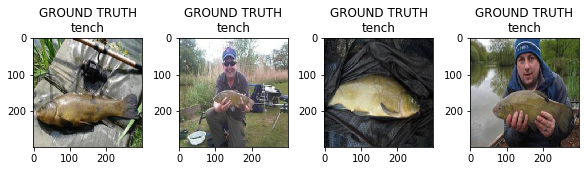

In [5]:
# show sample images from ImageNette
LEN = 4
N_COL = 4
N_ROW = 1


def img_to_np(image):
  np_img = image.numpy()
  return np.transpose(np_img, (1, 2, 0))


plt.figure(figsize=(N_COL * 2.5, N_ROW * 2))
data_iter = iter(dataset_loader)
for i in range(LEN):
  sample_image, sample_label = data_iter.next()
  plt.subplot(N_ROW, N_COL, i + 1)
  plt.imshow(img_to_np(sample_image.squeeze()))
  plt.title('GROUND TRUTH\n{}'.format(CLASS_NAMES[sample_label.squeeze()]))

In [6]:
# Validate model's base prediction accuracy (about 97%)
pbar = tqdm(dataset_loader)
pbar.set_description('Validate predictions')
pbar.set_postfix(acc='0.0%')

preds = []
acc = 0.0
i = 0
for image, label in pbar:
  # make a prediction
  prob = fmodel.forward(image.numpy())
  pred = np.argmax(prob)
  preds.append(pred)
  i += 1

  # calculate current accuracy
  acc += torch.sum(pred == label.data)
  current_acc = acc * 100 / i
  pbar.set_postfix(acc='{:.2f}%'.format(current_acc))

acc = acc * 100 / dataset_size
pbar.write('\nValidated with accuracy of: {:.2f}%'.format(acc))

Validate predictions: 100%|██████████| 100/100 [00:03<00:00, 32.46it/s, acc=97.00%]


Validated with accuracy of: 97.00%


In [15]:
# Perform an adversarial attack with FGSM
tic = time.time()
attack = foolbox.attacks.FGSM(fmodel, distance=foolbox.distances.Linf)

pbar = tqdm(dataset_loader)
pbar.set_description('Generate adversarials')

# iterate through images to generate adversarials
eps = [0.01 * i for i in range(0, 10)]
adversarials = []
for image, label in pbar:
  adv = attack(image.numpy(), label.numpy(), epsilons=eps)

  # if an attack fails under preferred criterions, `np.nan` is returned,
  #  in which case, we'll return the original image
  if np.isnan(adv).any():
    adv = image.numpy()
  adversarials.append(adv)

toc = time.time()
time_elapsed = toc - tic
pbar.write('\nAdversarials generated in: {:.2f}m {:.2f}s'.format(time_elapsed // 60, time_elapsed % 60))

Generate adversarials: 100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


Adversarials generated in: 0.00m 42.21s


In [16]:
# make predictions on adversarial examples
pbar = tqdm(dataset_loader)
pbar.set_description('Validate adversarials')
pbar.set_postfix(acc='0.00%')
i = 0
adv_acc = 0.0
adv_preds = []
adv_failed = []
for _, label in pbar:
  adv_prob = fmodel.forward(adversarials[i])
  adv_pred = np.argmax(adv_prob)
  adv_preds.append(adv_pred)

  # attack failed (adversarial == ground truth)
  if adv_pred == label.data:
    adv_failed.append(i)

  i += 1

  adv_acc += torch.sum(adv_pred == label.data)
  cur_adv_acc = adv_acc * 100 / i
  pbar.set_postfix(acc='{:.2f}%'.format(cur_adv_acc))

adv_acc = adv_acc * 100 / dataset_size
pbar.write('\nModel predicted adversarials with an accuracy of: {:.2f}%'.format(adv_acc))

Validate adversarials: 100%|██████████| 100/100 [00:02<00:00, 38.33it/s, acc=36.00%]


Model predicted adversarials with an accuracy of: 36.00%


In [17]:
# Index image and labels to access them with indices
# overhead may be high, run with caution
visualize_images = []
visualize_labels = []
for image, label in dataset_loader:
  visualize_images.append(image.numpy().squeeze())
  visualize_labels.append(label.numpy().squeeze())

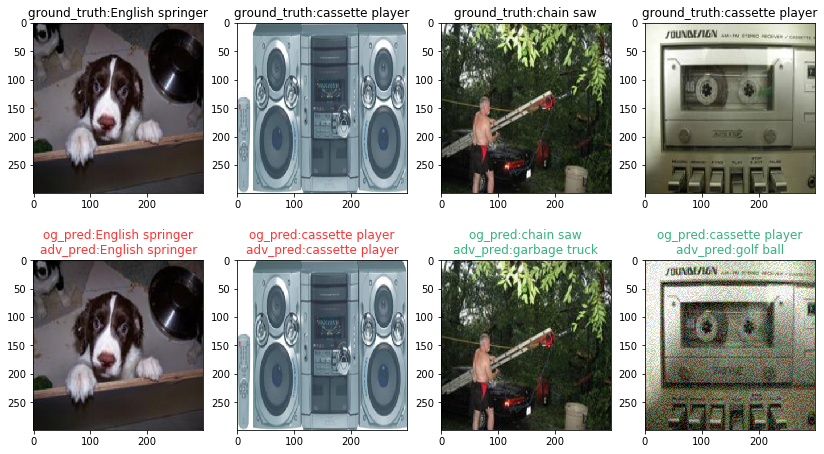

In [19]:
# Visualize adversarial examples with prediction
# and ground truth side by side

# sample images to preview
adv_all_indices = [i for i in range(0, 100)]
adv_success = [item for item in adv_all_indices if item not in adv_failed]

# pick sample images to preview, 2 failed and 2 success
VISUALIZE_IMAGE_INDICE = []
VISUALIZE_IMAGE_INDICE.append(random.choices(adv_failed, k=2))
VISUALIZE_IMAGE_INDICE.append(random.choices(adv_success, k=2))
# flatten list
VISUALIZE_IMAGE_INDICE = [item for sublist in VISUALIZE_IMAGE_INDICE for item in sublist]

LEN = len(VISUALIZE_IMAGE_INDICE)
N_COL = 4
N_ROW = 2

# plot adversarial examples predictions
plt.figure(figsize=(N_COL * 3.5, N_ROW * 4))
for i, indice in enumerate(VISUALIZE_IMAGE_INDICE):
  plt.subplot(N_ROW, N_COL, i + 1)
  plt.imshow(np.transpose(visualize_images[indice], (1, 2, 0)))
  plt.title('ground_truth:{}'.format(CLASS_NAMES[visualize_labels[indice]]))

for i, indice in enumerate(VISUALIZE_IMAGE_INDICE):
  plt.subplot(N_ROW, N_COL, LEN + i + 1)
  plt.imshow(np.transpose(adversarials[indice].squeeze(), (1, 2, 0)))

  # if attack success - title green; else - title red
  color = ('#36b37e' if not preds[indice] == adv_preds[indice] else '#ff3333')
  # plot prediction / adversarial side by side
  plt.title('og_pred:{}\nadv_pred:{}'.format(CLASS_NAMES[preds[indice]], CLASS_NAMES[adv_preds[indice]]), color=color)

plt.show()